In [234]:
import astropy.coordinates as coord
import astropy.table as table
#from astropy.table import Table
import astropy.units as u

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf

import sys
import importlib
sys.path.append('../../scripts/')
sys.path.append('../../data/')
import serializers_tf
import potential_tf
import toy_systems
import flow_ffjord_tf
import plot_flow_projections
import fit_all
import utils
import h5py

import os

In [235]:
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib import colors

%matplotlib inline
dpi, fontsize = 140, 10
plt.rc('text', usetex=True)
plt.rc('figure', dpi=dpi)
plt.rc('font', size=fontsize)

 # Harmonic potential mock data
 
Mock data for the potential
$$
\varphi(x, y, z) = \frac{1}{2}\omega^2 \left((x - r_c)^2 + y^2\right) +
\frac{1}{2}kz^2
$$

This is a harmonic potential in $x-y$ with exponentially falling disk in $z$.

The mock data is generated for $r_\mathrm{inner} <= r=\sqrt{x^2+y^2+z^2} <= r_\mathrm{outer}$ (imitating DR3)
for a rotating clump of stars with a normal profile in $x-y-z-v_x-v_y-v_z$. The clump looks stationary in a rotating frame $(0,0,\omega)$.

The distribution function (satisfying CBE and stationarity in rotating frame) is
\begin{align*}
f(x, y, z, vx, vy, vz) = &g(x, \sigma_r)\cdot\\
                         &g(y, \sigma_r)\cdot\\
                         &g(z, \sigma_z)\cdot\\
                         &g(v_x, |\omega|\sigma_r)\cdot\\
                         &g(v_y - |\omega| r_c, \omega\sigma_r)\cdot\\
                         &g(v_z, |\omega|\sigma_z),
\end{align*}
where
$$
g(x, \sigma_r) = \frac{1}{\sigma_r \sqrt{2\pi}}\exp\left(-\frac{x^2}{2\sigma_r^2}\right)
$$
is the normal distribution.

Free parameters: $\omega$, $r_c$, $\sigma_r$, $r_\mathrm{inner}$, $r_\mathrm{outer}$, $\sigma_z$, $\vec u$. Chosen to imitate Gaia DR3.

$$
\frac{\partial f}{\partial t} + \vec u \cdot \frac{\partial f}{\partial \vec x} + \vec{w} \cdot \frac{\partial f}{\partial \vec v}= 0,
$$

$$
\vec u = \vec \Omega\times (\vec x - \vec x_0) + \vec v_0,
$$

$$
\vec w = \vec \Omega\times (\vec v - \vec v_0),
$$


In [236]:
#galpy for symplec https://docs.galpy.org/en/latest/reference/orbitint.html method='symplec6_c'
# Actually make your own integrator from scipy

In [488]:
import h5py

def load_data(fname):
    _,ext = os.path.splitext(fname)
    if ext == '.json':
        with open(fname, 'r') as f:
            o = json.load(f)
        d = tf.constant(np.array(o['eta'], dtype='f4'))
    elif ext in ('.h5', '.hdf5'):
        with h5py.File(fname, 'r') as f:
            o = f['eta'][:].astype('f4')
            attrs = dict(f['eta'].attrs.items())
        d = tf.constant(o)
    else:
        raise ValueError(f'Unrecognized input file extension: "{ext}"')
    return d, attrs

fname = '../../data/s_Harmonic.h5'
fname_noisy = '../../data/s_Harmonic_noisy.h5'
eta_noisy, attrs = load_data(fname_noisy)
eta_noisy = eta_noisy.numpy()
eta_clean, _ = load_data(fname)
eta_clean = eta_clean.numpy()

In [489]:
coords_noisy = plot_flow_projections.calc_coords(eta_noisy)
coords_clean = plot_flow_projections.calc_coords(eta_clean)

In [490]:
[print(line) for line in attrs.items()];
print(len(eta_clean))

('omega', -0.25)
('omega_z', -0.4)
('parallax_max', 15.873015873015873)
('parallax_min', 0.3333333333333333)
('r_c', 8.3)
('r_inner', 0.063)
('r_outer', 3.0)
('sigma_r', 0.45)
('sigma_z', 0.35)
('spatial_unit', 'kpc')
('velocity_unit', 'km/cs')
2097152


In [492]:
n = 2**17          # 131072 stars
r_c = 8.3          # 8.3 kpc       literature
omega = -0.25      # -25 km/s/kpc  taken from one of the rotating fits for DR3
sigma_r = 0.45     # 400 pc        chosen by gut feeling
sigma_z = 0.35     # 0.35 kp       literature
omega_z = -0.4
r_inner = 0.063    # 63 pc         inner limit of pop3 from DR3  (2.0 < M_G < 4.0)
r_outer = 0.398    # 398 pc        outer limit of pop3 from DR3  (2.0 < M_G < 4.0)

#u0 = np.array((-0.128, -2.222, -0.077))
u0 = np.array((0., 0., 0.))

rng = np.random.default_rng(seed=1)

np.mean(rng.normal(loc=0, scale=np.abs(omega)*sigma_r, size=117923))

-0.00033875147524846795

In [443]:
print(np.std(eta_clean[:,0]))

0.4499701


Plotting 1D marginal distributions ...
cart


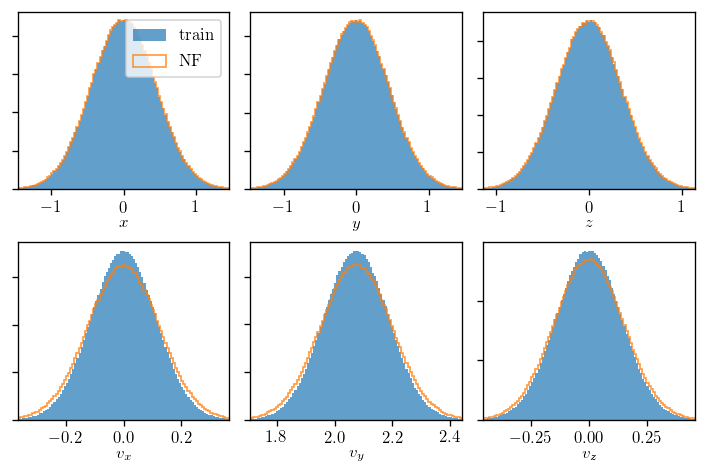

cyl


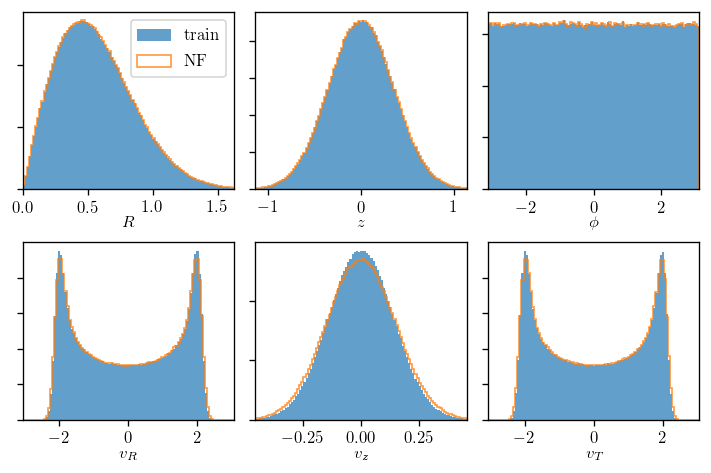

sph


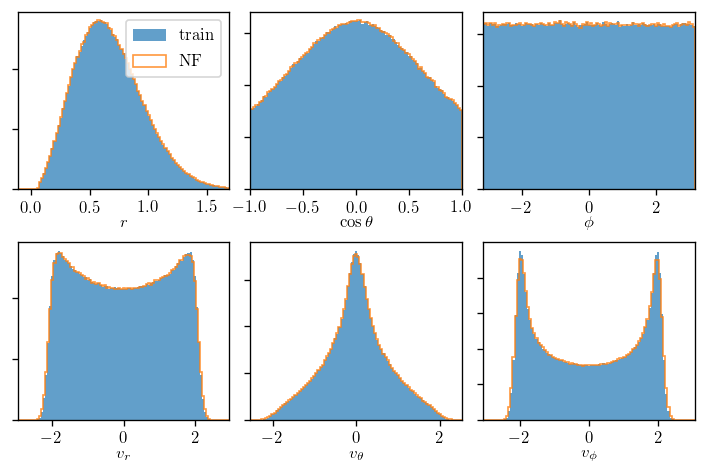

In [493]:
print('Plotting 1D marginal distributions ...')
for coordsys in ['cart', 'cyl', 'sph']:
    print(coordsys)
    plot_flow_projections.plot_1d_marginals(
        coords_clean, coords_noisy, None,
        coordsys=coordsys,
        fig_fmt=())
    plt.show()

### Evolve the distribution forward in time

In [494]:
t_eval = 1.3#2*np.pi/0.25 # units 1kpc/100km/s = 3.08e14s = 9.76 Myrs

ix, iy, iz, ivx, ivy, ivz = 0, 1, 2, 3, 4, 5

eta_eval_clean, eta_eval_noisy = [], []
for i, eta in enumerate([eta_clean, eta_noisy]):
    x0 = ((eta[:, ix]-r_c)**2 + (eta[:, ivx] - u0[ix])**2/omega**2)**0.5
    alpha = np.arctan2((eta[:, ix] - r_c), (eta[:, ivx] - u0[ix])/omega)
    #alpha = np.arcsin((eta[:, ix] - r_c)/x0)
    #beta = np.arccos((eta[:, ivx] + u0[ix])/x0/omega)
    x_eval = r_c + x0*np.sin(omega*t_eval + alpha)
    vx_eval = u0[ix] + x0*omega*np.cos(omega*t_eval + alpha)
    
    y0 = (eta[:, iy]**2 +(eta[:, ivy] - u0[iy])**2/omega**2)**0.5
    alpha = np.arctan2(eta[:, iy], (eta[:, ivy] - u0[iy])/omega)
    #alpha = np.arcsin(eta[:, iy]/y0)
    y_eval = y0*np.sin(omega*t_eval + alpha)
    vy_eval = u0[iy] + y0*omega*np.cos(omega*t_eval + alpha)
    
    z0 = (eta[:, iz]**2 + (eta[:, ivz] - u0[iz])**2/omega_z**2)**0.5
    alpha = np.arctan2(eta[:, iz], (eta[:, ivz] - u0[iz])/omega_z)
    z_eval = z0*np.sin(omega_z*t_eval + alpha)
    vz_eval = u0[iz] + z0*omega_z*np.cos(omega_z*t_eval + alpha)
    
    #bins = np.linspace(-2, 2, 200)
    #ns, *_ = plt.hist(eta[:, iz], bins=bins, histtype='step', label='old', alpha=0.6)
    #ns, *_ = plt.hist(z_eval, bins=bins, histtype='step', label='new', alpha=0.6)

    if i == 0:
        eta_eval_clean = np.stack((x_eval, y_eval, z_eval, vx_eval, vy_eval, vz_eval), axis=1)
    else:
        eta_eval_noisy = np.stack((x_eval, y_eval, z_eval, vx_eval, vy_eval, vz_eval), axis=1)

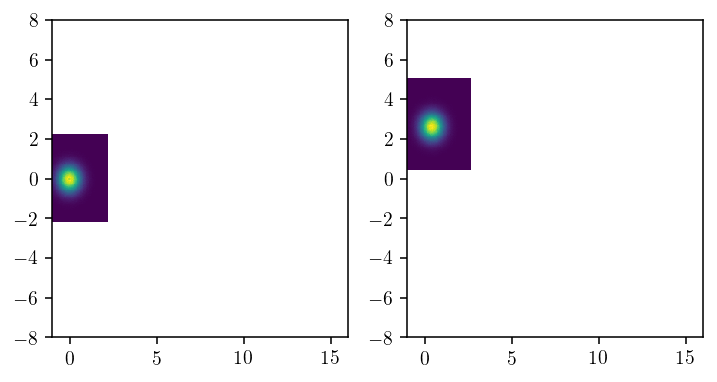

In [495]:
fig, axs = plt.subplots(1, 2, figsize=(6, 3))
axs[0].hist2d(eta_noisy[:, ix], eta_noisy[:, iy], bins=(100, 100), cmap=plt.cm.viridis);
axs[1].hist2d(eta_eval_noisy[:, ix], eta_eval_noisy[:, iy], bins=(100, 100), cmap=plt.cm.viridis);

for ax in axs:
    ax.set_xlim(-1, 16)
    ax.set_ylim(-8, 8)

In [496]:
# Rotate the results
for eta in (eta_eval_clean, eta_eval_noisy):
    theta = omega*t_eval
    new_x = r_c + (eta[:, ix] - r_c) * np.cos(theta) + eta[:, iy] * np.sin(theta)
    new_y = -(eta[:, ix] - r_c) * np.sin(theta) + eta[:, iy] * np.cos(theta)
    new_vx = u0[ix] + (eta[:, ivx] - u0[ix]) * np.cos(theta) + (eta[:, ivy] - u0[iy]) * np.sin(theta)
    new_vy = u0[iy] - (eta[:, ivx] - u0[ix]) * np.sin(theta) + (eta[:, ivy] - u0[iy]) * np.cos(theta)
    
    eta[:, ix] = new_x
    eta[:, iy] = new_y
    eta[:, ivx] = new_vx
    eta[:, ivy] = new_vy

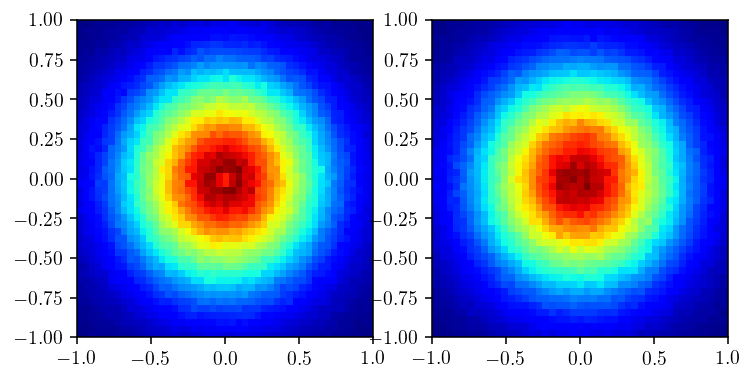

In [497]:
fig, axs = plt.subplots(1, 2, figsize=(6, 3))
axs[0].hist2d(eta_noisy[:, ix], eta_noisy[:, iy], bins=(100, 100), cmap=plt.cm.jet);
axs[1].hist2d(eta_eval_noisy[:, ix], eta_eval_noisy[:, iy], bins=(100, 100), cmap=plt.cm.jet);

for ax in axs:
    ax.set_xlim(-1, 1)
    ax.set_ylim(-1, 1)

In [498]:
coords_eval_noisy = plot_flow_projections.calc_coords(eta_eval_noisy)
coords_eval_clean = plot_flow_projections.calc_coords(eta_eval_clean)

Plotting 1D marginal distributions ...
cart


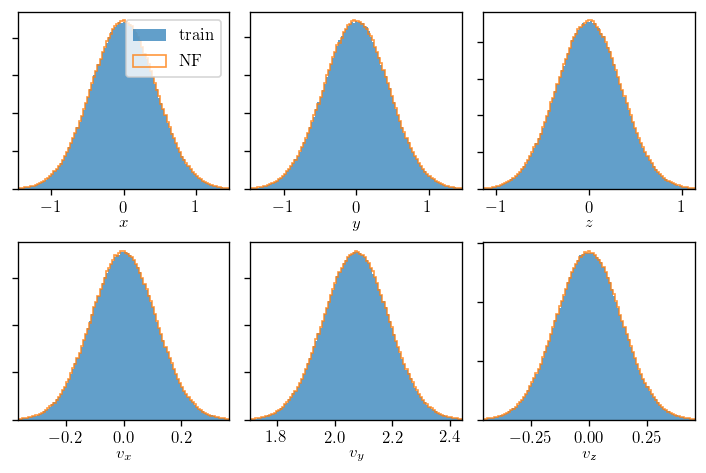

cyl


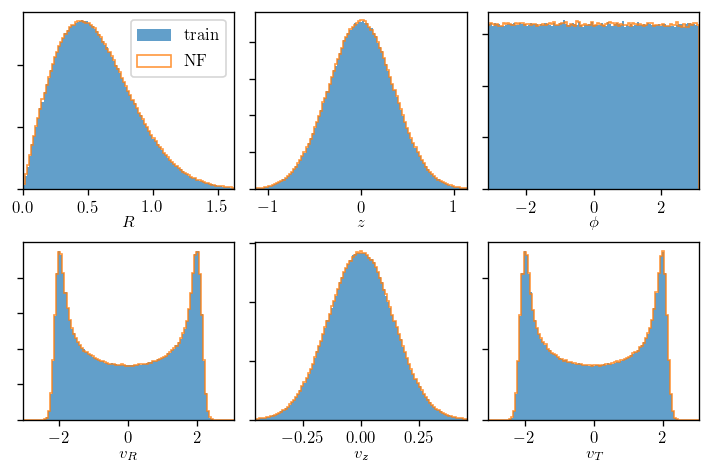

sph


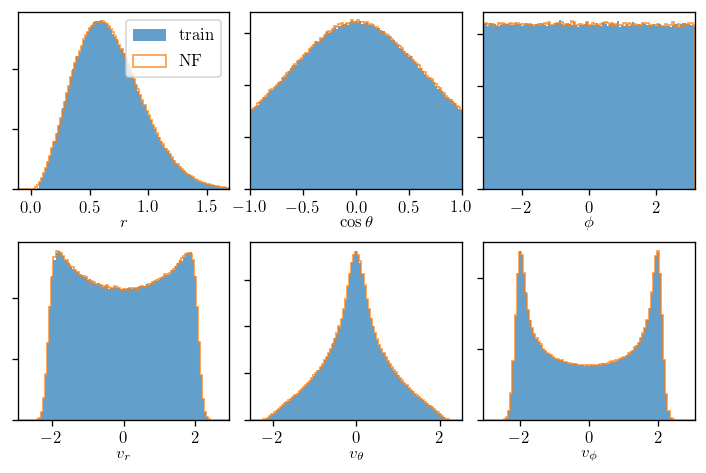

In [499]:
print('Plotting 1D marginal distributions ...')
for coordsys in ['cart', 'cyl', 'sph']:
    print(coordsys)
    plot_flow_projections.plot_1d_marginals(
        coords_clean, coords_eval_clean, None,
        coordsys=coordsys,
        fig_fmt=())
    plt.show()

### Debug in z

In [462]:
# test with z only

def sample_normal(rng, n, sigma, mu):
    return rng.normal(loc=mu, scale=sigma, size=n)

n = 1000000
eta = np.zeros((n, 2))

iz, ivz, = 0, 1

rng = np.random.default_rng(seed = 7)

eta[:, iz] = sample_normal(rng, n, sigma_z, 0)
eta[:, ivz] = sample_normal(rng, n, sigma_z*np.abs(omega_z), 0)

t_eval = 8*np.pi

z0 = (eta[:, iz]**2 + (eta[:, ivz])**2/omega_z**2)**0.5
alpha = np.arctan2(eta[:, iz], eta[:, ivz]/omega_z)
z_eval = z0*np.sin(omega_z*t_eval + alpha)
vz_eval = z0*omega_z*np.cos(omega_z*t_eval + alpha)

In [463]:
print(len(eta[:, iz]), len(z_eval), sigma_z)

1000000 1000000 0.35


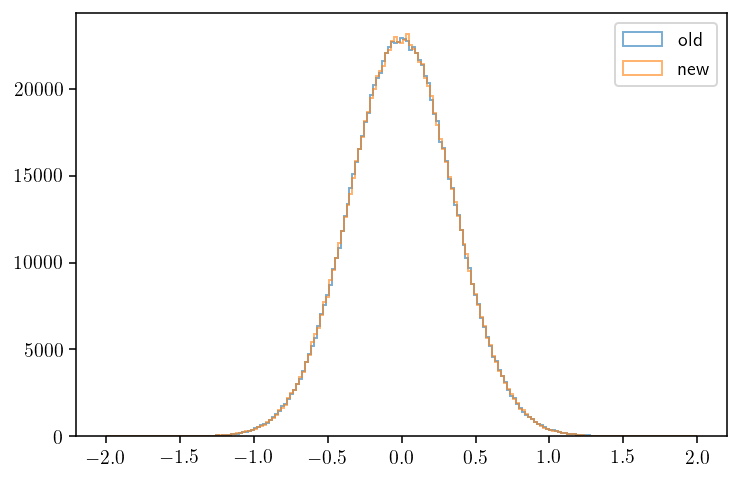

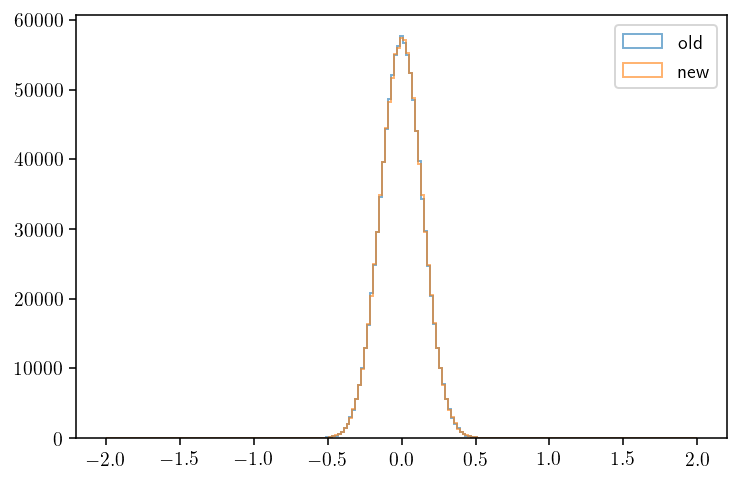

In [464]:
bins = np.linspace(-2, 2, 200)
ns, *_ = plt.hist(eta[:, iz], bins=bins, histtype='step', label='old', alpha=0.6)
ns, *_ = plt.hist(z_eval, bins=bins, histtype='step', label='new', alpha=0.6)
plt.legend()
plt.show()
ns, *_ = plt.hist(eta[:, ivz], bins=bins, histtype='step', label='old', alpha=0.6)
ns, *_ = plt.hist(vz_eval, bins=bins, histtype='step', label='new', alpha=0.6)
plt.legend()
plt.show()

0.3499172813327977 0.3830136


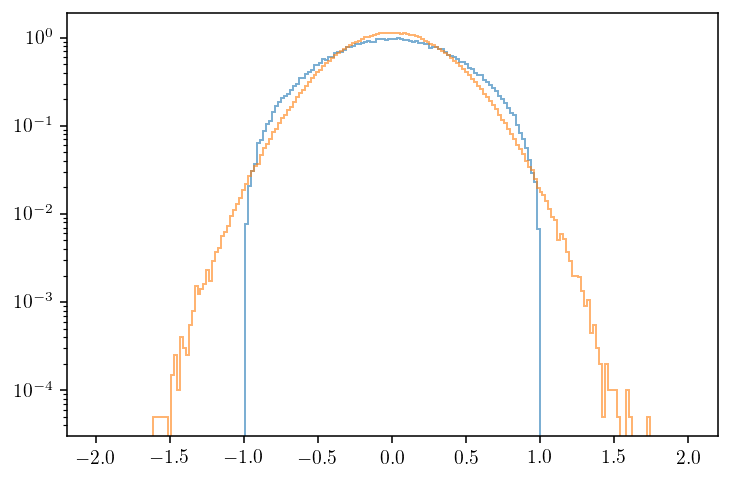

In [252]:
bins = np.linspace(-2, 2, 200)
ns, *_ = plt.hist(eta_noisy[:, iz], bins=bins, histtype='step', label='old', alpha=0.6, density=True)
ns, *_ = plt.hist(eta[:, iz], bins=bins, histtype='step', label='new', alpha=0.6, density=True)
print(np.std(eta[:, iz]), np.std(eta_noisy[:, iz]))
plt.yscale('log')

## Generate flow samples

In [503]:
df_deta_clean = np.zeros_like(eta_clean)

ix, iy, iz, ivx, ivy, ivz = 0, 1, 2, 3, 4, 5

df_deta_clean, df_deta_noisy = [], []

# Get params of the harmonic
_, attrs = plot_flow_projections.load_training_data('../../data/s_Harmonic.h5', True)
n = len(eta_clean)
print(n)
r_c = attrs['r_c']
sigma_r = attrs['sigma_r']
sigma_z = attrs['sigma_z']
omega = attrs['omega']
omega_z = attrs['omega_z']
r_inner = attrs['r_inner']
r_outer = attrs['r_outer']
#u0 = np.array((-0.128, -2.222, -0.077))
u0 = np.array((0., 0., 0.))


def g(x, sigma, mu=0):
    return np.exp(-(x - mu)**2/2/sigma**2)/sigma/(2*np.pi)**0.5

def dg_dx_over_g(x, sigma, mu=0):
    return -(x - mu)/sigma**2

def f(eta):
    return g(eta[:, ix], sigma_r) *\
           g(eta[:, iy], sigma_r) *\
           g(eta[:, iz], sigma_z) *\
           g(eta[:, ivx] - u0[ix], np.abs(omega)*sigma_r) *\
           g(eta[:, ivy] - u0[iy] + omega*r_c, np.abs(omega)*sigma_r) *\
           g(eta[:, ivz] - u0[iz], np.abs(omega_z)*sigma_z)
        
for i, eta in enumerate([eta_clean, eta_noisy]):
    f_eta = f(eta)
    
    x, y, z, vx, vy, vz = eta[:, ix], eta[:, iy], eta[:, iz], eta[:, ivx], eta[:, ivy], eta[:, ivz]
    df_dx = dg_dx_over_g(x, sigma_r)*f_eta
    df_dy = dg_dx_over_g(y, sigma_r)*f_eta
    df_dz = dg_dx_over_g(z, sigma_z)*f_eta
    df_dvx = dg_dx_over_g(vx - u0[ix], sigma_r*omega)*f_eta
    df_dvy = dg_dx_over_g(vy - u0[iy] + omega*r_c, sigma_r*omega)*f_eta
    df_dvz = dg_dx_over_g(vz - u0[iz], sigma_z*omega_z)*f_eta
    """df_dx = -eta[:, ix]/sigma_r**2*f_eta
    df_dy = -eta[:, iy]/sigma_r**2*f_eta
    df_dz = -eta[:, iz]/sigma_z**2*f_eta
    df_dvx = -(eta[:, ivx] + u0[ix])/sigma_r**2/omega**2*f_eta
    df_dvy = -(eta[:, ivy] + u0[iy] - omega*r_c)/sigma_r**2/omega**2*f_eta
    df_dvz = -(eta[:, ivz] + u0[iz])/sigma_z**2/omega_z**2*f_eta"""
    
    if i == 0:
        df_deta_clean = np.stack((df_dx, df_dy, df_dz, df_dvx, df_dvy, df_dvz), axis=1)
    else:
        df_deta_noisy = np.stack((df_dx, df_dy, df_dz, df_dvx, df_dvy, df_dvz), axis=1)

2097152


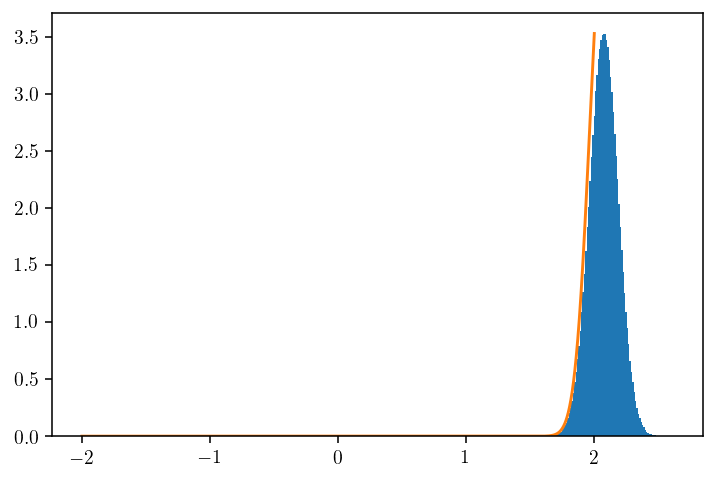

In [504]:
# Sanity check that f matches with training data

lims = (-2, 2)
i = ivy
ns, *_ = plt.hist(eta_clean[:, i], bins=100, density=True)
eta_fit = np.zeros((10000, 6))
eta_fit[:, i] = np.linspace(lims[0], lims[1], eta_fit.shape[0])
plt.plot(eta_fit[:, i], f(eta_fit)*np.max(ns)/np.max(f(eta_fit)))

In [502]:
import os
from pathlib import Path

def save_df_data(df_data, fname):
    # Make the directory if it doesn't exist
    Path(os.path.split(fname)[0]).mkdir(parents=True, exist_ok=True)

    kw = dict(compression='lzf', chunks=True)
    with h5py.File(fname, 'w') as f:
        for key in df_data:
            f.create_dataset(key, data=df_data[key], **kw)
            
            
print(len(eta_clean))
save_df_data({'eta': eta_clean, 'df_deta': df_deta_clean}, '../../data/harmonic_ideal_samples/df_iclean_gradients.h5')
#save_df_data({'eta': eta_clean, 'df_deta': df_deta_clean}, '../../runs/ideal_harmonic_v1/data/df_iclean_gradients.h5')
print(len(eta_noisy))
save_df_data({'eta': eta_noisy, 'df_deta': df_deta_noisy}, '../../data/harmonic_ideal_samples/df_inoisy_gradients.h5')
#save_df_data({'eta': eta_noisy, 'df_deta': df_deta_noisy}, '../../runs/ideal_harmonic_noisy_v1/data/df_inoisy_gradients.h5')

2097152
2097152


In [341]:
len(df_deta_clean)

524288

## 3. Analysing ideal generated sample

In [505]:
import plot_potential
import plot_flow_projections

class Object(object):
    pass

args = Object()
#args.potential = '../runs/gdr3_pad_bright_noagsel_pop3_v2/models/Phi_nn64_rot_v2/'
run_dir = '../../runs/ideal_harmonic_v2/'
#args.ideal_samples = f'{run_dir}data/df_iclean_gradients.h5'
args.ideal_samples = '../../data/harmonic_ideal_samples/df_iclean_gradients.h5'
args.potential = f'{run_dir}models/Phi/'
args.input = '../../data/Harmonic.h5'

phi_model = plot_potential.load_potential(args.potential)
eta_train, attrs = plot_flow_projections.load_training_data(args.input, True)
with h5py.File(args.ideal_samples, 'r') as f:
    eta_ideal = f['eta'][:]
    df_deta_ideal = f['df_deta'][:]


[print(line) for line in attrs.items()];

n = len(eta_train)
r_c = attrs['r_c']
sigma_r = attrs['sigma_r']
sigma_z = attrs['sigma_z']
omega = attrs['omega']
omega_z = attrs['omega_z']
r_inner = attrs['r_inner']
r_outer = attrs['r_outer']

loaded PhiNN(n_hidden=4, hidden_size=512) from ../../runs/ideal_harmonic_v2/models/Phi/Phi-221
loaded {'n_dim': 3, 'name': 'FrameShift'} from ../../runs/ideal_harmonic_v2/models/Phi/Phi-221
('omega', -0.25)
('omega_z', -0.4)
('parallax_max', 15.873015873015873)
('parallax_min', 1.0)
('r_c', 8.3)
('r_inner', 0.063)
('r_outer', 1.0)
('sigma_r', 0.45)
('sigma_z', 0.35)
('spatial_unit', 'kpc')
('velocity_unit', 'km/cs')


In [506]:
class PhiIdeal:
    def __init__(self, omega, omega_z):
        self.omega = omega
        self.omega_z = omega_z
        
    def phi(self, eta):
        return self.omega**2*((eta[:,1] - r_c)**2 + eta[:,1]**2)/2 + self.omega_z**2*eta[:,2]**2/2
    
    def gradphi(self, eta):
        grad_x = self.omega**2*(eta[:,0] - r_c)
        grad_y = self.omega**2*eta[:,1]
        grad_z = self.omega_z**2*eta[:,2]
        return np.hstack((grad_x.reshape(-1, 1), grad_y.reshape(-1, 1), grad_z.reshape(-1, 1)))

phi_ideal = PhiIdeal(omega, omega_z)

In [507]:
_, dphi_dq,_ = potential_tf.calc_phi_derivatives(phi_model['phi'], eta_ideal[:,:3], return_phi=True)

In [508]:
print(os.path.split(args.potential)[0])

../../runs/ideal_harmonic_v2/models/Phi


Text(0.5, 1.0, '$(\\partial f/\\partial t)_\\mathrm{CBE+stat}$')

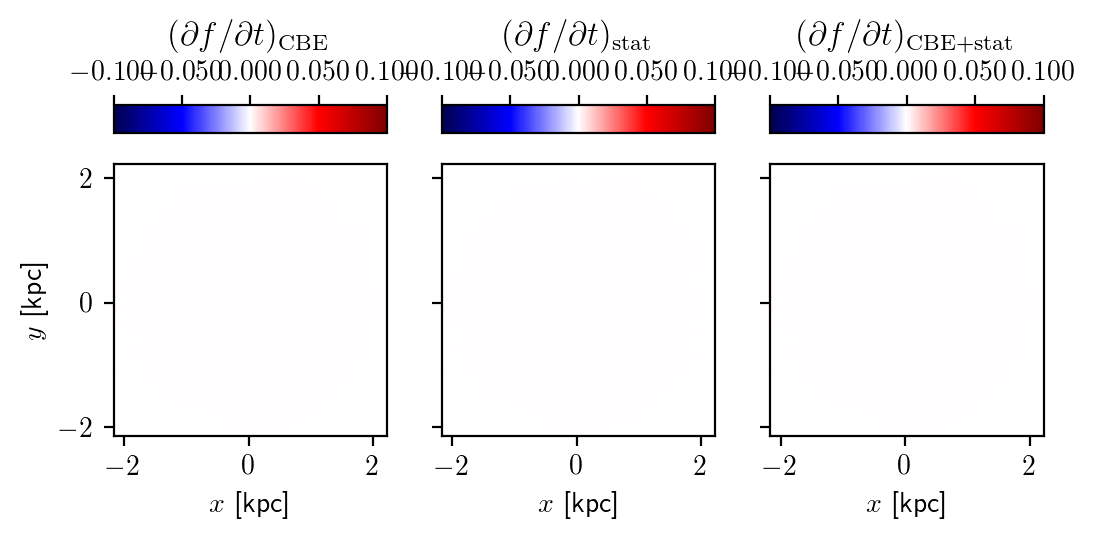

In [509]:
from scipy.stats import binned_statistic_2d

fig,(all_axs) = plt.subplots(2, 3,
        figsize=(6,2.2),
        dpi=200,
        gridspec_kw=dict(width_ratios=[2,2,2], height_ratios=[0.2, 2]))
axs = all_axs[1,:]
caxs = all_axs[0,:]

model_omega = phi_model['fs']._omega.numpy()
model_u0 = np.array((phi_model['fs']._u_x.numpy(), phi_model['fs']._u_y.numpy(), phi_model['fs']._u_z.numpy()))

pdf_dt_CBE_ideal = -np.sum(eta_ideal[:, 3:]*df_deta_ideal[:, :3], axis=1) +\
                    np.sum(dphi_dq.numpy()*df_deta_ideal[:, 3:], axis=1)


ix, iy, ivx, ivy = 0, 1, 3, 4
pdf_dt_stat_ideal = -model_omega*((eta_ideal[:, ix] - r_c)*df_deta_ideal[:, iy] -\
                     eta_ideal[:, iy]*df_deta_ideal[:, ix] +\
                     (eta_ideal[:, ivx] - model_u0[ix])*df_deta_ideal[:, ivy] -\
                     (eta_ideal[:, ivy] - model_u0[iy])*df_deta_ideal[:, ivx]) -\
                     np.sum(model_u0*df_deta_ideal[:,:3], axis=1)

labels = ['$x$ [kpc]', '$y$ [kpc]', '$z$ [kpc]']
ix, iy = 0, 1

for i in range(3):
    axs[i].set_xlabel(labels[ix])
axs[0].set_ylabel(labels[iy])
axs[1].set_yticklabels([])
axs[2].set_yticklabels([])

xmin, xmax, ymin, ymax = eta_ideal[:, ix].min(), eta_ideal[:, iy].max(), eta_ideal[:, iy].min(), eta_ideal[:, iy].max()
x_bins = np.linspace(xmin, xmax, 32)
y_bins = np.linspace(ymin, ymax, 32)
    

# Ideal CBE discrepancy
ret = binned_statistic_2d(eta_ideal[:, ix], eta_ideal[:, iy], pdf_dt_CBE_ideal, statistic=np.mean, bins=[x_bins, y_bins])
divnorm = colors.TwoSlopeNorm(vcenter=0.)
im = axs[0].imshow(ret.statistic.T, origin='lower', extent=(xmin, xmax, ymin, ymax), cmap='seismic', norm=divnorm)
cb = fig.colorbar(im, cax=caxs[0], orientation='horizontal')
cb.ax.xaxis.set_ticks_position('top')
cb.ax.locator_params(nbins=5)
caxs[0].set_title('$(\partial f/\partial t)_\mathrm{CBE}$')

# Ideal CBE stationarity discrepancy
ret = binned_statistic_2d(eta_ideal[:, ix], eta_ideal[:, iy], pdf_dt_stat_ideal, statistic=np.mean, bins=[x_bins, y_bins])
divnorm = colors.TwoSlopeNorm(vcenter=0.)
im = axs[1].imshow(ret.statistic.T, origin='lower', extent=(xmin, xmax, ymin, ymax), cmap='seismic', norm=divnorm)
cb = fig.colorbar(im, cax=caxs[1], orientation='horizontal')
cb.ax.xaxis.set_ticks_position('top')
cb.ax.locator_params(nbins=5)
caxs[1].set_title('$(\partial f/\partial t)_\mathrm{stat}$')

# CBE+rotating stationarity discrepancy
ret = binned_statistic_2d(eta_ideal[:, ix], eta_ideal[:, iy], pdf_dt_CBE_ideal - pdf_dt_stat_ideal, statistic=np.mean, bins=[x_bins, y_bins])
divnorm = colors.TwoSlopeNorm(vcenter=0.)
im = axs[2].imshow(ret.statistic.T, origin='lower', extent=(xmin, xmax, ymin, ymax), cmap='seismic', norm=divnorm)
cb = fig.colorbar(im, cax=caxs[2], orientation='horizontal')
cb.ax.xaxis.set_ticks_position('top')
cb.ax.locator_params(nbins=5)
caxs[2].set_title('$(\partial f/\partial t)_\mathrm{CBE+stat}$')

In [ ]:
from scipy.stats import binned_statistic_2d

fig,(all_axs) = plt.subplots(2, 3,
        figsize=(6,2.2),
        dpi=200,
        gridspec_kw=dict(width_ratios=[2,2,2], height_ratios=[0.2, 2]))
axs = all_axs[1,:]
caxs = all_axs[0,:]

pdf_dt_CBE_ideal = -np.sum(eta_ideal[:, 3:]*df_deta_ideal[:, :3], axis=1) +\
                    np.sum(phi_ideal.gradphi(eta_ideal)*df_deta_ideal[:, 3:], axis=1)


ix, iy, ivx, ivy = 0, 1, 3, 4
pdf_dt_stat_ideal = -omega*((eta_ideal[:, ix] - r_c)*df_deta_ideal[:, iy] -\
                            eta_ideal[:, iy]*df_deta_ideal[:, ix] +\
                            (eta_ideal[:, ivx] - u0[ix])*df_deta_ideal[:, ivy] -\
                            (eta_ideal[:, ivy] - u0[iy])*df_deta_ideal[:, ivx]) -\
                     np.sum(u0*df_deta_ideal[:,:3], axis=1)

labels = ['$x$ [kpc]', '$y$ [kpc]', '$z$ [kpc]']
ix, iy = 0, 1

for i in range(3):
    axs[i].set_xlabel(labels[ix])
axs[0].set_ylabel(labels[iy])
axs[1].set_yticklabels([])
axs[2].set_yticklabels([])

xmin, xmax, ymin, ymax = eta_ideal[:, ix].min(), eta_ideal[:, iy].max(), eta_ideal[:, iy].min(), eta_ideal[:, iy].max()
x_bins = np.linspace(xmin, xmax, 32)
y_bins = np.linspace(ymin, ymax, 32)
    

# Ideal CBE discrepancy
ret = binned_statistic_2d(eta_ideal[:, ix], eta_ideal[:, iy], pdf_dt_CBE_ideal, statistic=np.mean, bins=[x_bins, y_bins])
divnorm = colors.TwoSlopeNorm(vcenter=0.)
im = axs[0].imshow(ret.statistic.T, origin='lower', extent=(xmin, xmax, ymin, ymax), cmap='seismic', norm=divnorm)
cb = fig.colorbar(im, cax=caxs[0], orientation='horizontal')
cb.ax.xaxis.set_ticks_position('top')
cb.ax.locator_params(nbins=5)
caxs[0].set_title('$(\partial f/\partial t)_\mathrm{CBE}$')

# Ideal CBE stationarity discrepancy
ret = binned_statistic_2d(eta_ideal[:, ix], eta_ideal[:, iy], pdf_dt_stat_ideal, statistic=np.mean, bins=[x_bins, y_bins])
divnorm = colors.TwoSlopeNorm(vcenter=0.)
im = axs[1].imshow(ret.statistic.T, origin='lower', extent=(xmin, xmax, ymin, ymax), cmap='seismic', norm=divnorm)
cb = fig.colorbar(im, cax=caxs[1], orientation='horizontal')
cb.ax.xaxis.set_ticks_position('top')
cb.ax.locator_params(nbins=5)
caxs[1].set_title('$(\partial f/\partial t)_\mathrm{stat}$')

# CBE+rotating stationarity discrepancy
ret = binned_statistic_2d(eta_ideal[:, ix], eta_ideal[:, iy], pdf_dt_CBE_ideal - pdf_dt_stat_ideal, statistic=np.mean, bins=[x_bins, y_bins])
divnorm = colors.TwoSlopeNorm(vcenter=0.)
im = axs[2].imshow(ret.statistic.T, origin='lower', extent=(xmin, xmax, ymin, ymax), cmap='seismic', norm=divnorm)
cb = fig.colorbar(im, cax=caxs[2], orientation='horizontal')
cb.ax.xaxis.set_ticks_position('top')
cb.ax.locator_params(nbins=5)
caxs[2].set_title('$(\partial f/\partial t)_\mathrm{CBE+stat}$')

In [ ]:
from scipy.stats import binned_statistic_2d

fig,(all_axs) = plt.subplots(2, 3,
        figsize=(6,2.2),
        dpi=200,
        gridspec_kw=dict(width_ratios=[2,2,2], height_ratios=[0.2, 2]))
axs = all_axs[1,:]
caxs = all_axs[0,:]


ix, iy, ivx, ivy = 0, 1, 3, 4

# v \cdot \pdv{f}{r}
# Omega (x - x_c) \pdv{f}{x}
# Omega y \pdv{f}{y}
# Omega v_0 \cdot \pdv{f}{r}
term1 = np.sum(eta_ideal[:, 3:]*df_deta_ideal[:, :3], axis=1) +\
        omega*eta_ideal[:, iy]*df_deta_ideal[:, ix] -\
        omega*(eta_ideal[:, ix] - r_c)*df_deta_ideal[:, iy] -\
        np.sum(u0*df_deta_ideal[:,:3], axis=1)

term2 = -np.sum(phi_ideal.gradphi(eta_ideal)*df_deta_ideal[:, 3:], axis=1) +\
        omega*(eta_ideal[:, ivy] - u0[iy])*df_deta_ideal[:, ivx] -\
        omega*(eta_ideal[:, ivx] - u0[ix])*df_deta_ideal[:, ivy]

term2corr = -omega**2*((eta_ideal[:, ix] - r_c)*df_deta_ideal[:, ivx] + eta_ideal[:, iy]*df_deta_ideal[:, ivy])

print(term1+term2+term2corr)


pdf_dt_CBE_ideal = -np.sum(eta_ideal[:, 3:]*df_deta_ideal[:, :3], axis=1) +\
                    np.sum(phi_ideal.gradphi(eta_ideal)*df_deta_ideal[:, 3:], axis=1)


ix, iy, ivx, ivy = 0, 1, 3, 4
pdf_dt_stat_ideal = -omega*((eta_ideal[:, ix] - r_c)*df_deta_ideal[:, iy] -\
                            eta_ideal[:, iy]*df_deta_ideal[:, ix] +\
                            (eta_ideal[:, ivx] - u0[ix])*df_deta_ideal[:, ivy] -\
                            (eta_ideal[:, ivy] - u0[iy])*df_deta_ideal[:, ivx]) -\
                     np.sum(u0*df_deta_ideal[:,:3], axis=1)


labels = ['$x$ [kpc]', '$y$ [kpc]', '$z$ [kpc]']

for i in range(3):
    axs[i].set_xlabel(labels[ix])
axs[0].set_ylabel(labels[iy])
axs[1].set_yticklabels([])
axs[2].set_yticklabels([])

xmin, xmax, ymin, ymax = eta_ideal[:, ix].min(), eta_ideal[:, iy].max(), eta_ideal[:, iy].min(), eta_ideal[:, iy].max()
x_bins = np.linspace(xmin, xmax, 32)
y_bins = np.linspace(ymin, ymax, 32)
    

# Ideal CBE discrepancy
ret = binned_statistic_2d(eta_ideal[:, ix], eta_ideal[:, iy], term1, statistic=np.mean, bins=[x_bins, y_bins])
divnorm = colors.TwoSlopeNorm(vcenter=0.)
im = axs[0].imshow(ret.statistic.T, origin='lower', extent=(xmin, xmax, ymin, ymax), cmap='seismic', norm=divnorm)
cb = fig.colorbar(im, cax=caxs[0], orientation='horizontal')
cb.ax.xaxis.set_ticks_position('top')
cb.ax.locator_params(nbins=5)
caxs[0].set_title('$(\partial f/\partial t)_\mathrm{CBE}$')

# Ideal CBE stationarity discrepancy
ret = binned_statistic_2d(eta_ideal[:, ix], eta_ideal[:, iy], term2, statistic=np.mean, bins=[x_bins, y_bins])
divnorm = colors.TwoSlopeNorm(vcenter=0.)
im = axs[1].imshow(ret.statistic.T, origin='lower', extent=(xmin, xmax, ymin, ymax), cmap='seismic', norm=divnorm)
cb = fig.colorbar(im, cax=caxs[1], orientation='horizontal')
cb.ax.xaxis.set_ticks_position('top')
cb.ax.locator_params(nbins=5)
caxs[1].set_title('$(\partial f/\partial t)_\mathrm{stat}$')

# CBE+rotating stationarity discrepancy
ret = binned_statistic_2d(eta_ideal[:, ix], eta_ideal[:, iy], term2corr, statistic=np.mean, bins=[x_bins, y_bins])
divnorm = colors.TwoSlopeNorm(vcenter=0.)
im = axs[2].imshow(ret.statistic.T, origin='lower', extent=(xmin, xmax, ymin, ymax), cmap='seismic', norm=divnorm)
cb = fig.colorbar(im, cax=caxs[2], orientation='horizontal')
cb.ax.xaxis.set_ticks_position('top')
cb.ax.locator_params(nbins=5)
caxs[2].set_title('$(\partial f/\partial t)_\mathrm{CBE+stat}$')

In [ ]:
from scipy.stats import binned_statistic_2d

fig,(all_axs) = plt.subplots(2, 3,
        figsize=(6,2.2),
        dpi=200,
        gridspec_kw=dict(width_ratios=[2,2,2], height_ratios=[0.2, 2]))
axs = all_axs[1,:]
caxs = all_axs[0,:]

pdf_dt_CBE_ideal = -np.sum(eta_ideal[:, 3:]*df_deta_ideal[:, :3], axis=1) +\
                    np.sum(phi_ideal.gradphi(eta_ideal)*df_deta_ideal[:, 3:], axis=1)


ix, iy, ivx, ivy = 0, 1, 3, 4
pdf_dt_stat_ideal = -omega*((eta_ideal[:, ix] - r_c)*df_deta_ideal[:, iy] -\
                            eta_ideal[:, iy]*df_deta_ideal[:, ix] +\
                            (eta_ideal[:, ivx] - u0[ix])*df_deta_ideal[:, ivy] -\
                            (eta_ideal[:, ivy] - u0[iy])*df_deta_ideal[:, ivx]) -\
                     np.sum(u0*df_deta_ideal[:,:3], axis=1)

labels = ['$x$ [kpc]', '$y$ [kpc]', '$z$ [kpc]']
ix, iy = 0, 1

for i in range(3):
    axs[i].set_xlabel(labels[ix])
axs[0].set_ylabel(labels[iy])
axs[1].set_yticklabels([])
axs[2].set_yticklabels([])

xmin, xmax, ymin, ymax = eta_ideal[:, ix].min(), eta_ideal[:, iy].max(), eta_ideal[:, iy].min(), eta_ideal[:, iy].max()
x_bins = np.linspace(xmin, xmax, 32)
y_bins = np.linspace(ymin, ymax, 32)
    

# Ideal CBE discrepancy
ret = binned_statistic_2d(eta_ideal[:, ix], eta_ideal[:, iy], pdf_dt_CBE_ideal, statistic=np.mean, bins=[x_bins, y_bins])
divnorm = colors.TwoSlopeNorm(vcenter=0.)
im = axs[0].imshow(ret.statistic.T, origin='lower', extent=(xmin, xmax, ymin, ymax), cmap='seismic', norm=divnorm)
cb = fig.colorbar(im, cax=caxs[0], orientation='horizontal')
cb.ax.xaxis.set_ticks_position('top')
cb.ax.locator_params(nbins=5)
caxs[0].set_title('$(\partial f/\partial t)_\mathrm{CBE}$')

# Ideal CBE stationarity discrepancy
ret = binned_statistic_2d(eta_ideal[:, ix], eta_ideal[:, iy], pdf_dt_stat_ideal, statistic=np.mean, bins=[x_bins, y_bins])
divnorm = colors.TwoSlopeNorm(vcenter=0.)
im = axs[1].imshow(ret.statistic.T, origin='lower', extent=(xmin, xmax, ymin, ymax), cmap='seismic', norm=divnorm)
cb = fig.colorbar(im, cax=caxs[1], orientation='horizontal')
cb.ax.xaxis.set_ticks_position('top')
cb.ax.locator_params(nbins=5)
caxs[1].set_title('$(\partial f/\partial t)_\mathrm{stat}$')

# CBE+rotating stationarity discrepancy
ret = binned_statistic_2d(eta_ideal[:, ix], eta_ideal[:, iy], pdf_dt_CBE_ideal - pdf_dt_stat_ideal, statistic=np.mean, bins=[x_bins, y_bins])
divnorm = colors.TwoSlopeNorm(vcenter=0.)
im = axs[2].imshow(ret.statistic.T, origin='lower', extent=(xmin, xmax, ymin, ymax), cmap='seismic', norm=divnorm)
cb = fig.colorbar(im, cax=caxs[2], orientation='horizontal')
cb.ax.xaxis.set_ticks_position('top')
cb.ax.locator_params(nbins=5)
caxs[2].set_title('$(\partial f/\partial t)_\mathrm{CBE+stat}$')

In [ ]:
from scipy.stats import binned_statistic_2d

fig,(all_axs) = plt.subplots(2, 3,
        figsize=(6,2.2),
        dpi=200,
        gridspec_kw=dict(width_ratios=[2,2,2], height_ratios=[0.2, 2]))
axs = all_axs[1,:]
caxs = all_axs[0,:]

pdf_dt_CBE_ideal = -np.sum(eta_ideal[:, 3:]*df_deta_ideal[:, :3], axis=1) +\
                    np.sum(phi_ideal.gradphi(eta_ideal)*df_deta_ideal[:, 3:], axis=1)


r_c = 8.3
ix, iy, ivx, ivy = 0, 1, 3, 4
a, b = 2, 1
pdf_dt_stat_ideal = -omega*((eta_ideal[:, ix] - r_c)*df_deta_ideal[:, iy] -\
                            eta_ideal[:, iy]*df_deta_ideal[:, ix] +\
                            (a*eta_ideal[:, ivx] - a*u0[ix] + b*omega*eta_ideal[:, iy])*df_deta_ideal[:, ivy] -\
                            (a*eta_ideal[:, ivy] - a*u0[iy] - b*omega*(eta_ideal[:, ix] - r_c))*df_deta_ideal[:, ivx]) -\
                     np.sum(u0*df_deta_ideal[:,:3], axis=1)

labels = ['$x$ [kpc]', '$y$ [kpc]', '$z$ [kpc]']
ix, iy = 0, 1

for i in range(3):
    axs[i].set_xlabel(labels[ix])
axs[0].set_ylabel(labels[iy])
axs[1].set_yticklabels([])
axs[2].set_yticklabels([])

xmin, xmax, ymin, ymax = eta_ideal[:, ix].min(), eta_ideal[:, iy].max(), eta_ideal[:, iy].min(), eta_ideal[:, iy].max()
x_bins = np.linspace(xmin, xmax, 32)
y_bins = np.linspace(ymin, ymax, 32)
    

# Ideal CBE discrepancy
ret = binned_statistic_2d(eta_ideal[:, ix], eta_ideal[:, iy], pdf_dt_CBE_ideal, statistic=np.mean, bins=[x_bins, y_bins])
divnorm = colors.TwoSlopeNorm(vcenter=0.)
im = axs[0].imshow(ret.statistic.T, origin='lower', extent=(xmin, xmax, ymin, ymax), cmap='seismic', norm=divnorm)
cb = fig.colorbar(im, cax=caxs[0], orientation='horizontal')
cb.ax.xaxis.set_ticks_position('top')
cb.ax.locator_params(nbins=5)
caxs[0].set_title('$(\partial f/\partial t)_\mathrm{CBE}$')

# Ideal CBE stationarity discrepancy
ret = binned_statistic_2d(eta_ideal[:, ix], eta_ideal[:, iy], pdf_dt_stat_ideal, statistic=np.mean, bins=[x_bins, y_bins])
divnorm = colors.TwoSlopeNorm(vcenter=0.)
im = axs[1].imshow(ret.statistic.T, origin='lower', extent=(xmin, xmax, ymin, ymax), cmap='seismic', norm=divnorm)
cb = fig.colorbar(im, cax=caxs[1], orientation='horizontal')
cb.ax.xaxis.set_ticks_position('top')
cb.ax.locator_params(nbins=5)
caxs[1].set_title('$(\partial f/\partial t)_\mathrm{stat}$')

# CBE+rotating stationarity discrepancy
ret = binned_statistic_2d(eta_ideal[:, ix], eta_ideal[:, iy], pdf_dt_CBE_ideal - pdf_dt_stat_ideal, statistic=np.mean, bins=[x_bins, y_bins])
divnorm = colors.TwoSlopeNorm(vcenter=0.)
im = axs[2].imshow(ret.statistic.T, origin='lower', extent=(xmin, xmax, ymin, ymax), cmap='seismic', norm=divnorm)
cb = fig.colorbar(im, cax=caxs[2], orientation='horizontal')
cb.ax.xaxis.set_ticks_position('top')
cb.ax.locator_params(nbins=5)
caxs[2].set_title('$(\partial f/\partial t)_\mathrm{CBE+stat}$')